In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import os
import datetime
import numpy as np
import random
os.environ['OMP_NUM_THREADS'] = '13'

In [2]:
def get_device_time(frame):
    date = frame[1]
    date = str(date)
    space_pos = date.rfind(' ')
    time = date[space_pos + 1::]
    nd = datetime.datetime.strptime(time,"%H:%M:%S.%f")
    a_timedelta = nd - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds - 62288.672

def LongLat_Vproj(data_np_i, sens_is_obd = True):
    if sens_is_obd:
        cart_abs = (data_np_i[13] / 3.6)
        vLong = cart_abs * np.cos(data_np_i[7] * np.pi / 180) / 63642.78
        vLat = cart_abs * np.sin(data_np_i[7] * np.pi / 180) / 111000
        return((vLong, vLat))
    else:
        cart_abs = (data_np_i[4])
        vLong = cart_abs * np.cos(data_np_i[7] * np.pi / 180) / 63642.78
        vLat = cart_abs * np.sin(data_np_i[7] * np.pi / 180) / 111000
        return((vLong, vLat))
        
df = pd.read_csv('data1.csv')
data_np = df.to_numpy()
last_gps = data_np[0][0]

for i in range(len(data_np)):
    data_np[i][1] = get_device_time(data_np[i])
    

In [3]:
class FourDimKalman_U0:

    def __init__(self,F,Q,R,P0,x0,t0):
        self.F = F
        self.Q = Q
        self.R = R
        self.R.append(self.R[0] @ self.R[1] @ np.linalg.inv(self.R[0] + self.R[1]))
        self.P = P0
        self.x= x0
        self.T = t0
        
    def predict(self, T):
        self.F [0, 2]= T - self.T
        self.F [1, 3]= T - self.T
        self.T = T        
        
        self.x = self.F @ self.x + np.matrix([[random.normalvariate(0, np.sqrt(self.Q[0,0]))],
                                              [random.normalvariate(0, np.sqrt(self.Q[1,1]))],
                                              [random.normalvariate(0, np.sqrt(self.Q[2,2]))],
                                              [random.normalvariate(0, np.sqrt(self.Q[3,3]))]])
        
        self.P = self.F @ self.P @ self.F.transpose() + self.Q
        # print('P=\n',self.P,'\n')
        
    def update(self, Z, sens = 0):
        
        y = Z - self.x
        S = self.P + self.R[sens]
        K = self.P @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ self.P
        # print('K=\n',K,'\n')

In [25]:
errs_pred_m = [2, 2, 1, 1]
errs_gps = [0.5, 0.5, 1, 1]
errs_obd = [1, 1, 0.1, 0.1]
KF = FourDimKalman_U0(F=np.matrix([[1, 0, 0, 0],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]]),
                      
                      Q=np.matrix([[(errs_pred_m[0]/63642.78)**2, 0, 0, 0],
                                   [0, (errs_pred_m[1]/111000)**2, 0, 0],
                                   [0, 0, (errs_pred_m[2]/63642.78)**2, 0],
                                   [0, 0, 0, (errs_pred_m[3]/111000)**2]]),
                      
                      R = [np.matrix([[(errs_gps[0]/63642.78)**2, 0, 0, 0],
                                      [0, (errs_gps[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_gps[2]/63642.78)**2, 0],
                                      [0, 0, 0, (errs_gps[3]/111000)**2]]),
                           
                           np.matrix([[(errs_obd[0]/63642.78)**2, 0, 0, 0],
                                      [0, (errs_obd[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_obd[2]/63642.78)**2, 0],
                                      [0, 0, 0, (errs_obd[3]/111000)**2]])],
                      
                      P0=np.matrix([[1E-13, 0, 0, 0],
                                   [0, 1E-13, 0, 0],
                                   [0, 0, 1E-13, 0],
                                   [0, 0, 0, 1E-13]]),
                      
                      
                      x0=np.matrix([[data_np[0][2]],
                                    [data_np[0][3]],
                                    [0],
                                    [0]]),
                      
                      t0=0)

In [26]:
pred_pos = []
update_pos = []
update_by_gps = []

time_by_gps = []
time_update = []
time_pred = []

for frame in data_np:
    KF.predict(frame[1])
    pred_pos.append((KF.x[0, 0], KF.x[1, 0]))
    time_pred.append(frame[1])
    sensor = None
    if frame[0] != None and frame[1] != None and last_gps != frame[0]:
        sensor = 'BOTH'
        last_gps = frame[0]
    elif frame[1] != None:
        sensor = 'OBD'
    elif frame[0] != None and last_gps != frame[0]:
        sensor = 'GPS'
        last_gps = frame[0]

    V = None
    if sensor == None:
        continue
    if sensor == 'OBD':
        V = LongLat_Vproj(frame)
        
    if sensor == 'GPS':
        V = LongLat_Vproj(frame, sens_is_obd= False)
        
    if sensor == 'BOTH':
        VO = LongLat_Vproj(frame)
        VG = LongLat_Vproj(frame, sens_is_obd= False)

        V = (
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[0] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[0]),
             
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[1] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[1])
            )
        
    KF.update(np.matrix([[frame[2]],
                         [frame[3]],
                         [V[0]],
                         [V[1]]]),
             sens = 0 if sensor=='GPS' else 1 if sensor=='OBD' else 2)
    time_update.append(frame[1])
    if sensor == 'GPS' or sensor == 'BOTH':
        update_by_gps.append((KF.x[0, 0], KF.x[1, 0]))
        time_by_gps.append(frame[1])
    
    update_pos.append((KF.x[0, 0], KF.x[1, 0]))

In [27]:
import folium
map_moscow = folium.Map(location=[55.848558, 37.583105], zoom_start=20)
for cart in update_pos[::50]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="green")).add_to(map_moscow)
for cart in pred_pos[::50]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="gray")).add_to(map_moscow)
map_moscow

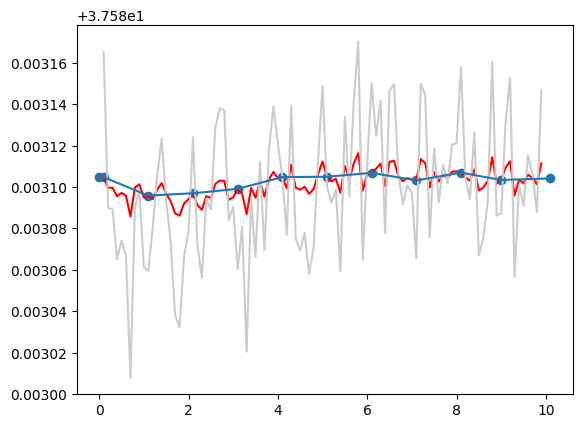

In [28]:
plt.plot(time_update[:100], [x[0] for x in update_pos][:100], c='r')
plt.plot(time_pred[1:100], [x[0] for x in pred_pos][1:100], c= '#cccccc')
plt.plot(time_by_gps[:12], [x[0] for x in update_by_gps][:12])
plt.scatter(time_by_gps[:12], [x[0] for x in update_by_gps][:12])

In [8]:
what_gps_was_showing = update_by_gps
his_time = time_by_gps

low = 180
high = 240
for i in range(low*10 + 10,high*10 - 10):
    data_np[i][0] = None

In [9]:
errs_pred_m = [2, 2, 0.5, 0.5]
errs_gps = [2, 2, 1, 1]
errs_obd = [100, 100, 0.1, 0.1]
KF = FourDimKalman_U0(F=np.matrix([[1, 0, 0, 0],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]]),
                      
                      Q=np.matrix([[(errs_pred_m[0]/64000)**2, 0, 0, 0],
                                   [0, (errs_pred_m[1]/111000)**2, 0, 0],
                                   [0, 0, (errs_pred_m[2]/64000)**2, 0],
                                   [0, 0, 0, (errs_pred_m[3]/111000)**2]]),
                      
                      R = [np.matrix([[(errs_gps[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_gps[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_gps[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_gps[3]/111000)**2]]),
                           
                           np.matrix([[(errs_obd[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_obd[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_obd[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_obd[3]/111000)**2]])],
                      
                      P0=np.matrix([[1E-13, 0, 0, 0],
                                   [0, 1E-13, 0, 0],
                                   [0, 0, 1E-13, 0],
                                   [0, 0, 0, 1E-13]]),
                      
                      
                      x0=np.matrix([[data_np[0][2]],
                                    [data_np[0][3]],
                                    [0],
                                    [0]]),
                      
                      t0=0)
pred_pos = []
update_pos = []
update_by_gps = []

time_by_gps = []
time_update = []
time_pred = []

for frame in data_np:
    KF.predict(frame[1])
    pred_pos.append((KF.x[0, 0], KF.x[1, 0]))
    time_pred.append(frame[1])
    sensor = None
    if frame[0] != None and frame[1] != None and last_gps != frame[0]:
        sensor = 'BOTH'
        last_gps = frame[0]
    elif frame[1] != None:
        sensor = 'OBD'
    elif frame[0] != None and last_gps != frame[0]:
        sensor = 'GPS'
        last_gps = frame[0]

    V = None
    if sensor == None:
        continue
    if sensor == 'OBD':
        V = LongLat_Vproj(frame)
        
    if sensor == 'GPS':
        V = LongLat_Vproj(frame, sens_is_obd= False)
        
    if sensor == 'BOTH':
        VO = LongLat_Vproj(frame)
        VG = LongLat_Vproj(frame, sens_is_obd= False)

        V = (
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[0] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[0]),
             
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[1] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[1])
            )
        
    KF.update(np.matrix([[frame[2]],
                         [frame[3]],
                         [V[0]],
                         [V[1]]]),
             sens = 0 if sensor=='GPS' else 1 if sensor=='OBD' else 2)
    time_update.append(frame[1])
    if sensor == 'GPS' or sensor == 'BOTH':
        update_by_gps.append((KF.x[0, 0], KF.x[1, 0]))
        time_by_gps.append(frame[1])
    
    update_pos.append((KF.x[0, 0], KF.x[1, 0]))
    

In [10]:
import folium
map_moscow = folium.Map(location=[55.848558, 37.583105], zoom_start=20)
for cart in update_pos[::20]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="green")).add_to(map_moscow)
for cart in pred_pos[::20]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="gray")).add_to(map_moscow)
map_moscow

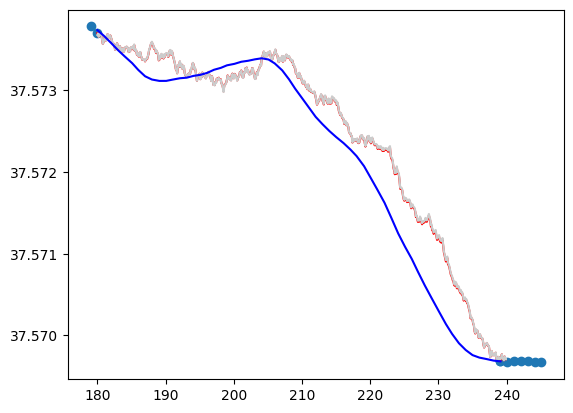

In [11]:

plt.plot(time_update[10*low:10*high], [x[0] for x in update_pos][10*low:10*high], c='r')
plt.plot(time_pred[10*low:10*high], [x[0] for x in pred_pos][10*low:10*high], c= '#cccccc')
plt.scatter(time_by_gps[low:low+10], [x[0] for x in update_by_gps][low:low+10])
plt.plot(his_time[low:high], [x[0] for x in what_gps_was_showing][low:high], c = 'b')

In [12]:
df = pd.read_csv('data1.csv')
data_np = df.to_numpy()
last_gps = data_np[0][0]

for i in range(len(data_np)):
    data_np[i][1] = get_device_time(data_np[i])

In [13]:
low = 180
high = 240
for i in range(low*10 + 10,high*10 - 10):
    data_np[i][14] = None

In [14]:
errs_pred_m = [2, 2, 0.5, 0.5]
errs_gps = [2, 2, 1, 1]
errs_obd = [100, 100, 0.1, 0.1]
KF = FourDimKalman_U0(F=np.matrix([[1, 0, 0, 0],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]]),
                      
                      Q=np.matrix([[(errs_pred_m[0]/64000)**2, 0, 0, 0],
                                   [0, (errs_pred_m[1]/111000)**2, 0, 0],
                                   [0, 0, (errs_pred_m[2]/64000)**2, 0],
                                   [0, 0, 0, (errs_pred_m[3]/111000)**2]]),
                      
                      R = [np.matrix([[(errs_gps[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_gps[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_gps[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_gps[3]/111000)**2]]),
                           
                           np.matrix([[(errs_obd[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_obd[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_obd[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_obd[3]/111000)**2]])],
                      
                      P0=np.matrix([[1E-13, 0, 0, 0],
                                   [0, 1E-13, 0, 0],
                                   [0, 0, 1E-13, 0],
                                   [0, 0, 0, 1E-13]]),
                      
                      
                      x0=np.matrix([[data_np[0][2]],
                                    [data_np[0][3]],
                                    [0],
                                    [0]]),
                      
                      t0=0)
pred_pos = []
update_pos = []
update_by_gps = []

time_by_gps = []
time_update = []
time_pred = []

for frame in data_np:
    KF.predict(frame[1])
    pred_pos.append((KF.x[0, 0], KF.x[1, 0]))
    time_pred.append(frame[1])
    sensor = None
    if frame[0] != None and frame[14] != None and last_gps != frame[0]:
        sensor = 'BOTH'
        last_gps = frame[0]
    elif frame[14] != None:
        sensor = 'OBD'
    elif frame[0] != None and last_gps != frame[0]:
        sensor = 'GPS'
        last_gps = frame[0]

    V = None
    if sensor == None:
        continue
    if sensor == 'OBD':
        V = LongLat_Vproj(frame)
        
    if sensor == 'GPS':
        V = LongLat_Vproj(frame, sens_is_obd= False)
        
    if sensor == 'BOTH':
        VO = LongLat_Vproj(frame)
        VG = LongLat_Vproj(frame, sens_is_obd= False)

        V = (
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[0] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[0]),
             
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[1] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[1])
            )
        
    KF.update(np.matrix([[frame[2]],
                         [frame[3]],
                         [V[0]],
                         [V[1]]]),
             sens = 0 if sensor=='GPS' else 1 if sensor=='OBD' else 2)
    time_update.append(frame[1])
    if sensor == 'GPS' or sensor == 'BOTH':
        update_by_gps.append((KF.x[0, 0], KF.x[1, 0]))
        time_by_gps.append(frame[1])
    
    update_pos.append((KF.x[0, 0], KF.x[1, 0]))
    

In [15]:
map_moscow = folium.Map(location=[55.848558, 37.583105], zoom_start=20)
for cart in update_pos[::20]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="green")).add_to(map_moscow)
for cart in pred_pos[::20]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="gray")).add_to(map_moscow)
map_moscow

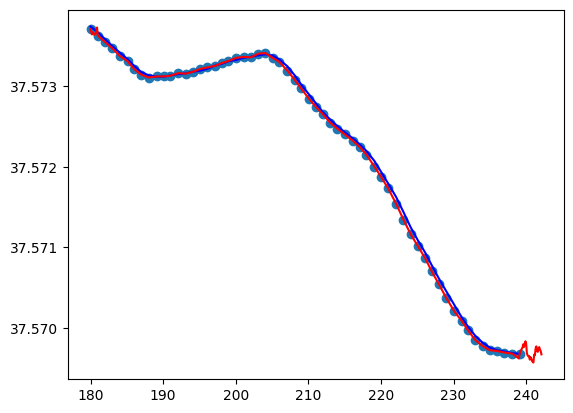

In [16]:
plt.plot(his_time[low:high], [x[0] for x in what_gps_was_showing][low:high], c = 'b')
plt.plot(time_update[10*low:10*low+100], [x[0] for x in update_pos][10*low:10*low+100], c='r')
plt.plot(time_pred[10*low:10*high-600], [x[0] for x in pred_pos][10*low:10*high-600], c= '#cccccc')
plt.scatter(time_by_gps[low:low+60], [x[0] for x in update_by_gps][low:low+60])


In [17]:
df = pd.read_csv('data1.csv')
data_np = df.to_numpy()
last_gps = data_np[0][0]

for i in range(len(data_np)):
    data_np[i][1] = get_device_time(data_np[i])

In [18]:
errs_pred_m = [2, 2, 0.5, 0.5]
errs_gps = [2, 2, 1, 1]
errs_obd = [100, 100, 0.1, 0.1]
KF = FourDimKalman_U0(F=np.matrix([[1, 0, 0, 0],
                                   [0, 1, 0, 0],
                                   [0, 0, 1, 0],
                                   [0, 0, 0, 1]]),
                      
                      Q=np.matrix([[(errs_pred_m[0]/64000)**2, 0, 0, 0],
                                   [0, (errs_pred_m[1]/111000)**2, 0, 0],
                                   [0, 0, (errs_pred_m[2]/64000)**2, 0],
                                   [0, 0, 0, (errs_pred_m[3]/111000)**2]]),
                      
                      R = [np.matrix([[(errs_gps[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_gps[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_gps[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_gps[3]/111000)**2]]),
                           
                           np.matrix([[(errs_obd[0]/64000)**2, 0, 0, 0],
                                      [0, (errs_obd[1]/111000)**2, 0, 0],
                                      [0, 0, (errs_obd[2]/64000)**2, 0],
                                      [0, 0, 0, (errs_obd[3]/111000)**2]])],
                      
                      P0=np.matrix([[1E-13, 0, 0, 0],
                                   [0, 1E-13, 0, 0],
                                   [0, 0, 1E-13, 0],
                                   [0, 0, 0, 1E-13]]),
                      
                      
                      x0=np.matrix([[data_np[0][2]],
                                    [data_np[0][3]],
                                    [0],
                                    [0]]),
                      
                      t0=0)
pred_pos = []
update_pos = []
update_by_gps = []

time_by_gps = []
time_update = []
time_pred = []

for frame in data_np:
    KF.predict(frame[1])
    pred_pos.append((KF.x[0, 0], KF.x[1, 0]))
    time_pred.append(frame[1])
    sensor = None
    if frame[0] != None and frame[14] != None and last_gps != frame[0]:
        sensor = 'BOTH'
        last_gps = frame[0]
    elif frame[14] != None:
        sensor = 'OBD'
    elif frame[0] != None and last_gps != frame[0]:
        sensor = 'GPS'
        last_gps = frame[0]

    V = None
    if sensor == None:
        continue
    if sensor == 'OBD':
        V = LongLat_Vproj(frame)
        
    if sensor == 'GPS':
        V = LongLat_Vproj(frame, sens_is_obd= False)
        
    if sensor == 'BOTH':
        VO = LongLat_Vproj(frame)
        VG = LongLat_Vproj(frame, sens_is_obd= False)

        V = (
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[0] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[0]),
             
            (KF.R[0][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VG[1] +
             KF.R[1][2,2]/(KF.R[0][2,2] + KF.R[1][2,2]) * VO[1])
            )
        
    KF.update(np.matrix([[frame[2]],
                         [frame[3]],
                         [V[0]],
                         [V[1]]]),
             sens = 0 if sensor=='GPS' else 1 if sensor=='OBD' else 2)
    time_update.append(frame[1])
    if sensor == 'GPS' or sensor == 'BOTH':
        update_by_gps.append((KF.x[0, 0], KF.x[1, 0]))
        time_by_gps.append(frame[1])
    
    update_pos.append((KF.x[0, 0], KF.x[1, 0]))
    

In [20]:
map_moscow = folium.Map(location=[55.848558, 37.583105], zoom_start=20)
for cart in update_pos[::20]:
    folium.Marker((cart[1],cart[0]), icon=folium.Icon(color="green")).add_to(map_moscow)

map_moscow